In [4]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import Scsv


In [5]:
# %matplotlib widget

In [6]:
%matplotlib

Using matplotlib backend: agg


In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sys
from operator import add

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import StopWordsRemover

In [8]:
spark = SparkSession.builder\
    .appName("MyProj")\
    .master("local[*]")\
    .config("spark.sql.repl.eagerEval.enabled", True)\
    .getOrCreate()

fname="hdfs://zuk:9000/dataset/twitter/Tweets.csv"

In [9]:
df = spark.read.option("header",True).csv(fname)\
    .select("airline_sentiment","text")

rter = RegexTokenizer(inputCol="text", outputCol="token", pattern="[\\W]+", minTokenLength=2)
tokenized = rter.transform(df.na.fill(''))

In [10]:
display(tokenized.select("airline_sentiment", "text","token"))

airline_sentiment,text,token
neutral,@VirginAmerica Wh...,"[virginamerica, w..."
positive,@VirginAmerica pl...,"[virginamerica, p..."
neutral,@VirginAmerica I ...,"[virginamerica, d..."
negative,"""@VirginAmerica i...","[virginamerica, i..."
negative,@VirginAmerica an...,"[virginamerica, a..."
negative,@VirginAmerica se...,"[virginamerica, s..."
,,[]
positive,@VirginAmerica ye...,"[virginamerica, y..."
neutral,@VirginAmerica Re...,"[virginamerica, r..."
positive,@virginamerica We...,"[virginamerica, w..."


In [11]:
remover = StopWordsRemover(inputCol="token", outputCol="rtoken")
removed = remover.transform(tokenized)
display(removed)
removed.count()

airline_sentiment,text,token,rtoken
neutral,@VirginAmerica Wh...,"[virginamerica, w...","[virginamerica, d..."
positive,@VirginAmerica pl...,"[virginamerica, p...","[virginamerica, p..."
neutral,@VirginAmerica I ...,"[virginamerica, d...","[virginamerica, d..."
negative,"""@VirginAmerica i...","[virginamerica, i...","[virginamerica, r..."
negative,@VirginAmerica an...,"[virginamerica, a...","[virginamerica, r..."
negative,@VirginAmerica se...,"[virginamerica, s...","[virginamerica, s..."
,,[],[]
positive,@VirginAmerica ye...,"[virginamerica, y...","[virginamerica, y..."
neutral,@VirginAmerica Re...,"[virginamerica, r...","[virginamerica, r..."
positive,@virginamerica We...,"[virginamerica, w...","[virginamerica, w..."


14837

In [12]:
oname = fname.replace("/", "").replace(":", "")
# !transform data

word2Vec = Word2Vec(vectorSize=3, minCount=1,
                    inputCol="rtoken", outputCol="vector")

model = word2Vec.fit(removed)


result = model.transform(removed)

In [19]:
def plotVecs(oname, wds, vecs, count):
    plt.ioff()
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    for i in range(count):
        coords = vecs[i][0].toArray()
        ax.scatter(*coords)
        pass

    # too much too slow and crowded, disabled
    # label = str(wds[i][0])
    # ax.text(*coords, label)

    plt.savefig(f"/opt/spark/myProj/plots/out-{oname}.png")
    return fig # in jupyter

In [16]:
wds1 = result.select("rtoken")\
    .filter("airline_sentiment = \"positive\" OR airline_sentiment = \"neutral\"")\
    .collect()
vecs1 = result.select("vector")\
    .filter("airline_sentiment = \"positive\" OR airline_sentiment = \"neutral\"")\
    .collect()

wds2 = result.select("rtoken")\
    .filter(result.airline_sentiment =="negative")\
    .collect()
vecs2 = result.select("vector")\
    .filter(result.airline_sentiment =="negative")\
    .collect()

cnt1 = len(vecs1)
cnt2 = len(vecs2)

In [17]:
display(wds1[0:5])
display(wds2[0:5])

[Row(rtoken=['virginamerica', 'dhepburn', 'said']),
 Row(rtoken=['virginamerica', 'plus', 've', 'added', 'commercials', 'experience', 'tacky']),
 Row(rtoken=['virginamerica', 'didn', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']),
 Row(rtoken=['virginamerica', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'ear', 'worm', 'won', 'go', 'away']),
 Row(rtoken=['virginamerica', 'really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hats', 'parody', 'https', 'co', 'mwpg7grezp'])]

[Row(rtoken=['virginamerica', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse']),
 Row(rtoken=['virginamerica', 'really', 'big', 'bad', 'thing']),
 Row(rtoken=['virginamerica', 'seriously', 'pay', '30', 'flight', 'seats', 'didn', 'playing']),
 Row(rtoken=['virginamerica', 'sfo', 'pdx', 'schedule', 'still', 'mia']),
 Row(rtoken=['virginamerica', 'flew', 'nyc', 'sfo', 'last', 'week', 'couldn', 'fully', 'sit', 'seat', 'due', 'two', 'large', 'gentleman', 'either', 'side', 'help'])]

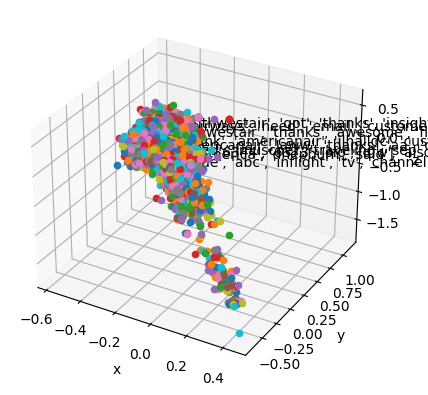

In [18]:
plotVecs(oname+"pos", wds1, vecs1, cnt1)


In [21]:
plotVecs(oname+"neg", wds2, vecs2, cnt2)

KeyboardInterrupt: 

In [22]:
model.findSynonyms("delayed",10)


word,similarity
effort,0.9996938705444336
unusual,0.9994428157806396
illiterate,0.9994289875030518
newborns,0.9991961717605591
armrest,0.9991430044174194
rudeness,0.9989446401596069
surveys,0.9988499283790588
1925,0.9986674785614014
research,0.9986106157302856
8004337300,0.9982445240020752


In [26]:
model.findSynonyms("great",10)

word,similarity
b11,0.9997805953025818
adam_karren,0.9996010065078735
1415,0.9995601177215576
5534,0.9992772936820984
409,0.9987597465515137
police,0.9987162947654724
theworst,0.9984032511711121
disrespectfully,0.9982711672782898
hubbys,0.9977509379386902
flight2149,0.9971078038215637


In [108]:
model.getVectors()

word,vector
incident,[0.15521873533725...
stillwaiting,[0.07911669462919...
flight1797,[0.10342511534690...
serious,[0.01050990819931...
brink,[-0.0308695919811...
dndoepqukz,[-0.1019947528839...
o5sifhp4rt,[7.03761354088783...
sxu,[0.08611654490232...
breaks,[-0.0168486218899...
dns,[-0.1032810881733...
